In [1]:
# ──────────── Experiment 1: Outlier Detection via MDDPA ────────────
import numpy as np
from sklearn.mixture      import GaussianMixture
from sklearn.ensemble     import RandomForestClassifier
from sklearn.metrics      import accuracy_score
import umap
import torch
import sys
import matplotlib.pyplot as plt
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
sys.path.append("..")
from dpa.dpa_fit import MDDPA   # point to your implementation

# ── 2) Simulate data via 2 D “truth” + random projection to D ──
import numpy as np

# 2 D samplers
def sample_in_2d(n):
    # centered at (0,0)
    return np.random.normal(loc=0, scale=1, size=(n, 2))

def sample_out_2d(n):
    # shifted (e.g. center at (3,0))
    return np.random.normal(loc=[2, 2], scale=1, size=(n, 2))

# dimensions
d2 = 2
D  = 20

# random projection matrix from 2 → D
P = np.random.randn(d2, D)

# noise level in the high‑D space
noise_scale = 0.05

# generate 2 D truth
X2_train     = sample_in_2d(1000)
X2_hold_in   = sample_in_2d(200)
X2_hold_out  = sample_out_2d(200)

# project into D‑dimensions (plus a bit of Gaussian noise)
X_train = X2_train @ P + noise_scale * np.random.randn(1000, D)

X_hold_in  = X2_hold_in @ P + noise_scale * np.random.randn(200, D)
X_hold_out = X2_hold_out @ P + noise_scale * np.random.randn(200, D)

X_hold = np.vstack([X_hold_in, X_hold_out])
y_hold = np.array([0]*len(X_hold_in) + [1]*len(X_hold_out))


# ── 3) Fit teacher (UMAP) on X_train ──
umap_model = umap.UMAP(n_components=2, random_state=0)
E_train   = umap_model.fit_transform(X_train)

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


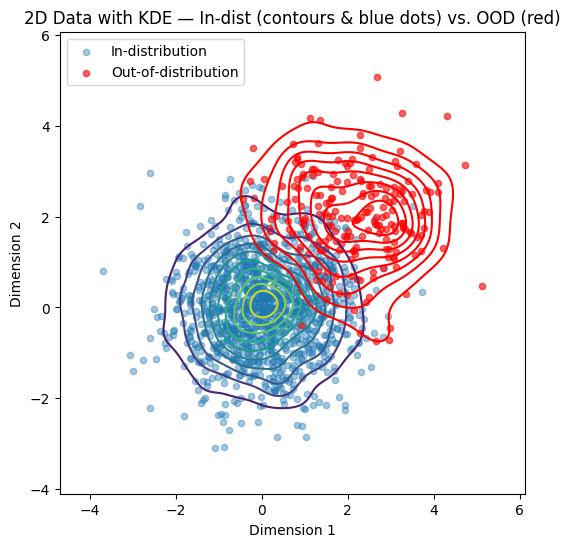

In [2]:
from scipy.stats import gaussian_kde

# assume these exist from your simulation:
# X2_train   (N×2), X2_hold_in (M×2), X2_hold_out (M×2)
X2_train     = sample_in_2d(1000)
X2_hold_in   = sample_in_2d(200)
X2_hold_out  = sample_out_2d(200)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# assume these are already defined:
# X2_train   (n_train × 2), X2_hold_in (n_in × 2), X2_hold_out (n_out × 2)

# 1) Combine all in‐distribution data
X_in  = np.vstack([X2_train, X2_hold_in])
X_out = X2_hold_out

# 2) Set up a grid over the 2D space
all_data = np.vstack([X_in, X_out])
xmin, ymin = all_data.min(axis=0) - 1
xmax, ymax = all_data.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# 3) Fit KDEs
kde_in  = gaussian_kde(X_in.T)
kde_out = gaussian_kde(X_out.T)
density_in  = np.reshape(kde_in(positions),  xx.shape)
density_out = np.reshape(kde_out(positions), xx.shape)

# 4) Plot
plt.figure(figsize=(6, 6))

# in‐dist contour (default color)
plt.contour(xx, yy, density_in, levels=10)

# out‐dist contour in red
plt.contour(xx, yy, density_out, levels=10, colors='red')

# scatter points
plt.scatter(X_in[:, 0], X_in[:, 1], s=20, alpha=0.4, label='In‑distribution')
plt.scatter(X_out[:, 0], X_out[:, 1], c='red', s=20, alpha=0.6, label='Out‑of‑distribution')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Data with KDE — In‑dist (contours & blue dots) vs. OOD (red)')
plt.legend()
plt.savefig("../plots/embed_gen_process.png", bbox_inches="tight")



In [3]:
X_hold.shape, E_train.shape

((400, 20), (1000, 2))

In [4]:

# ── 4) Distill with MDDPA ──
mddpa =  MDDPA(data_dim=20, latent_dims=[10, 2, 1, 0], num_layer=4, hidden_dim=200, coef_distill_latent=1e2, noise_dim=2, device=device)


Xt = torch.from_numpy(X_train).float().to(device)
Et = torch.from_numpy(E_train).float().to(device)

mddpa.train(Xt, Et, batch_size=250, num_epochs=500)


Running on CPU.

Start training with 4 batches each of size 250.

[Epoch 1] 5.3369, 5.3388, 5.3390, 5.0365
 pred 	5.5662, 5.5643, 5.5639, 5.7261
 var 	0.4585, 0.4510, 0.4498, 1.3791

[Epoch 100] 0.2103, 0.2033, 0.2082, 3.9725
 pred 	0.4653, 0.4640, 0.4634, 7.4297
 var 	0.5101, 0.5214, 0.5104, 6.9143

[Epoch 200] 0.1829, 0.1787, 0.1880, 3.9398
 pred 	0.3719, 0.3659, 0.3724, 7.8653
 var 	0.3780, 0.3744, 0.3689, 7.8510

[Epoch 300] 0.1724, 0.1677, 0.1723, 3.9385
 pred 	0.3425, 0.3392, 0.3444, 7.8692
 var 	0.3401, 0.3430, 0.3442, 7.8614

[Epoch 400] 0.1628, 0.1663, 0.1638, 3.9906
 pred 	0.3270, 0.3303, 0.3282, 7.9692
 var 	0.3284, 0.3281, 0.3288, 7.9571

[Epoch 500] 0.1635, 0.1645, 0.1653, 4.0371
 pred 	0.3255, 0.3273, 0.3284, 7.9014
 var 	0.3240, 0.3256, 0.3262, 7.7286



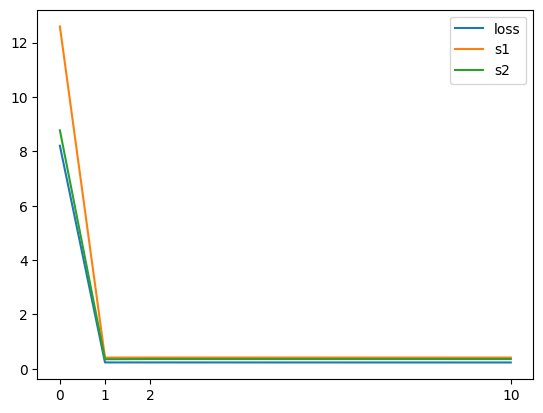

In [14]:
mddpa.plot_energy_loss(torch.from_numpy(X_hold).float().to(device), xscale='linear')

In [6]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score,roc_curve

E_pred_train = mddpa.encode(Xt, k= 2, mean=True, gen_sample_size=100).cpu().numpy()
err_train    = np.linalg.norm(E_train - E_pred_train, axis=1)
    # holdout errors
E_hold       = umap_model.transform(X_hold)
Eh_t         = torch.from_numpy(X_hold).float().to(device)
E_pred_hold  = mddpa.encode(Eh_t, k=2).cpu().numpy()
err_hold     = np.linalg.norm(E_hold - E_pred_hold, axis=1)

# ── 6) Empirical p‐values & metrics ──
p_vals = np.array([ (err_train >= e).mean() for e in err_hold ])
y_pred = (p_vals < 0.05).astype(int)

print("AUC:",   roc_auc_score(y_hold,     err_hold))
print("F1:",    f1_score(    y_hold, y_pred))
print("Recall:",recall_score(y_hold, y_pred))
print("Precision:",precision_score(y_hold, y_pred))

/Users/matthewshen/.pyenv/versions/mddpa/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC: 0.7489750000000001
F1: 0.6375
Recall: 0.51
Precision: 0.85


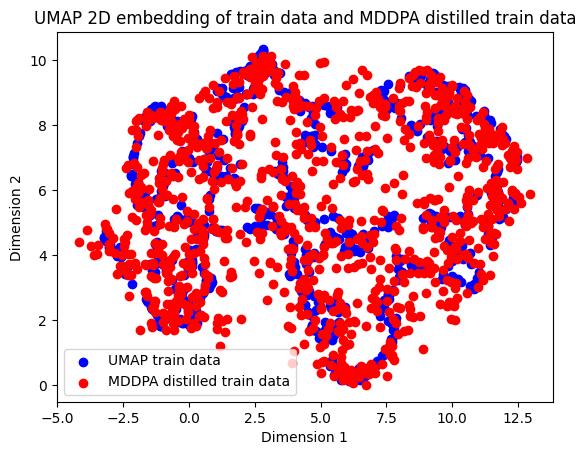

In [7]:
plt.scatter(E_train[:, 0], E_train[:, 1], c = 'blue', label='UMAP train data')
plt.scatter(E_pred_train[:, 0], E_pred_train[:, 1], c = 'red', label='MDDPA distilled train data')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP 2D embedding of train data and MDDPA distilled train data')
plt.legend()
#plt.savefig("../plots/embed_gen_process.png", bbox_inches="tight")

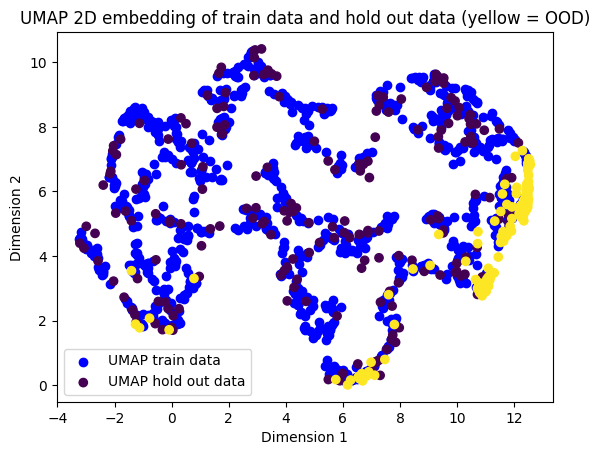

In [13]:
plt.scatter(E_train[:, 0], E_train[:, 1], c = 'blue', label='UMAP train data')
plt.scatter(E_hold[:, 0], E_hold[:, 1], c = y_hold, label='UMAP hold out data')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP 2D embedding of train data and hold out data (yellow = OOD)')
plt.legend()
plt.savefig("../plots/umap_hold_embed.png", bbox_inches="tight")

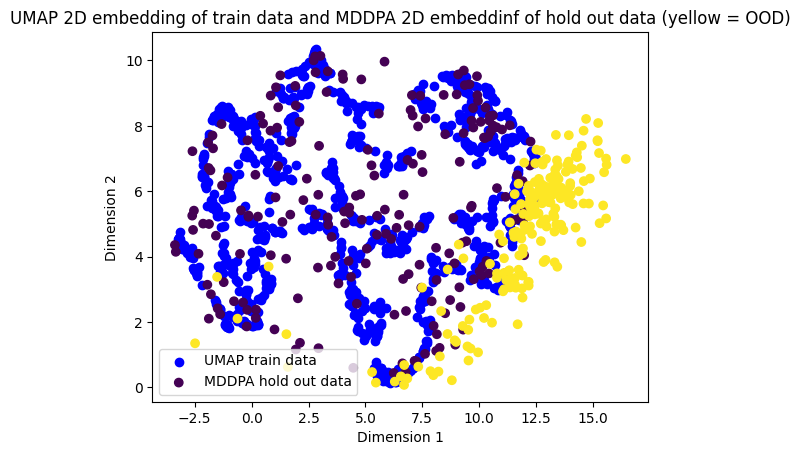

In [14]:
plt.scatter(E_train[:, 0], E_train[:, 1], c = 'blue', label='UMAP train data')
plt.scatter(E_pred_hold[:, 0], E_pred_hold[:, 1], c = y_hold, label='MDDPA hold out data')


plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP 2D embedding of train data and MDDPA 2D embeddinf of hold out data (yellow = OOD)')
plt.legend()
plt.savefig("../plots/mddpa_hold_embed.png", bbox_inches="tight")

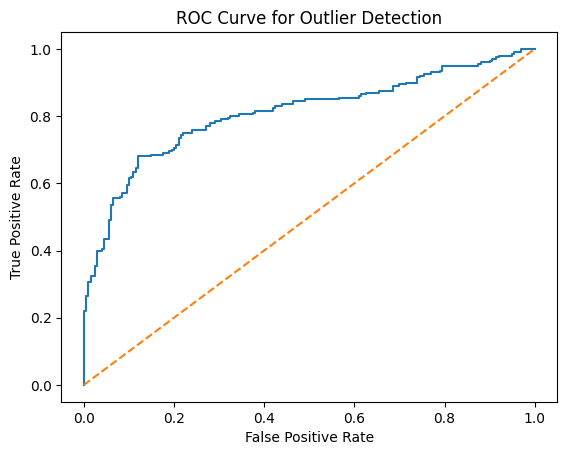

In [19]:
fpr, tpr, thresholds = roc_curve(y_hold, err_hold)
plt.figure()
plt.plot(fpr, tpr)                # ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Outlier Detection')
plt.show()

In [20]:
X_recon_train = mddpa.reconstruct(Xt, k= 2, mean=True).cpu().numpy()
recon_train    = np.linalg.norm(X_train - X_recon_train, axis=1)

X_recon_hold  = mddpa.reconstruct(torch.from_numpy(X_hold).float().to(device), k=2, mean=True).cpu().numpy()
recon_hold     = np.linalg.norm(X_hold - X_recon_hold, axis=1)

# ── 6) Empirical p‐values & metrics ──
p_vals = np.array([ (recon_train >= r).mean() for r in recon_hold ])
y_pred = (p_vals < 0.05).astype(int)

print("AUC:",   roc_auc_score(y_hold,     recon_hold))
print("F1:",    f1_score(    y_hold, y_pred))
print("Recall:",recall_score(y_hold, y_pred))
print("Precision:",precision_score(y_hold, y_pred))

AUC: 0.795575
F1: 0.7012195121951219
Recall: 0.575
Precision: 0.8984375


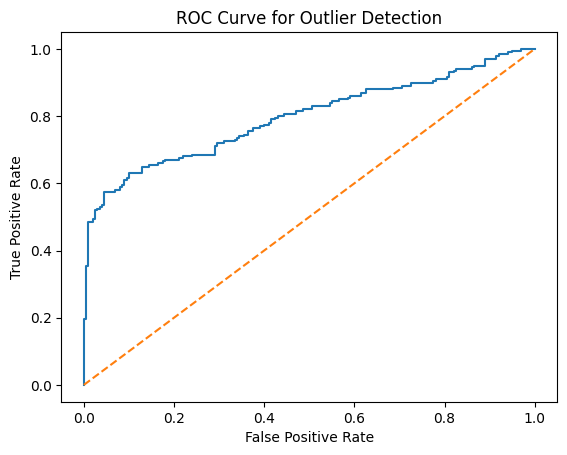

In [21]:
fpr, tpr, thresholds = roc_curve(y_hold, recon_hold)
plt.figure()
plt.plot(fpr, tpr)                # ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Outlier Detection')
plt.show()